In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob

from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [2]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [3]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [4]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [6]:

## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

WindowsPath('C:/Users/multicampus/Desktop/test/data')

In [7]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\A

In [5]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\A

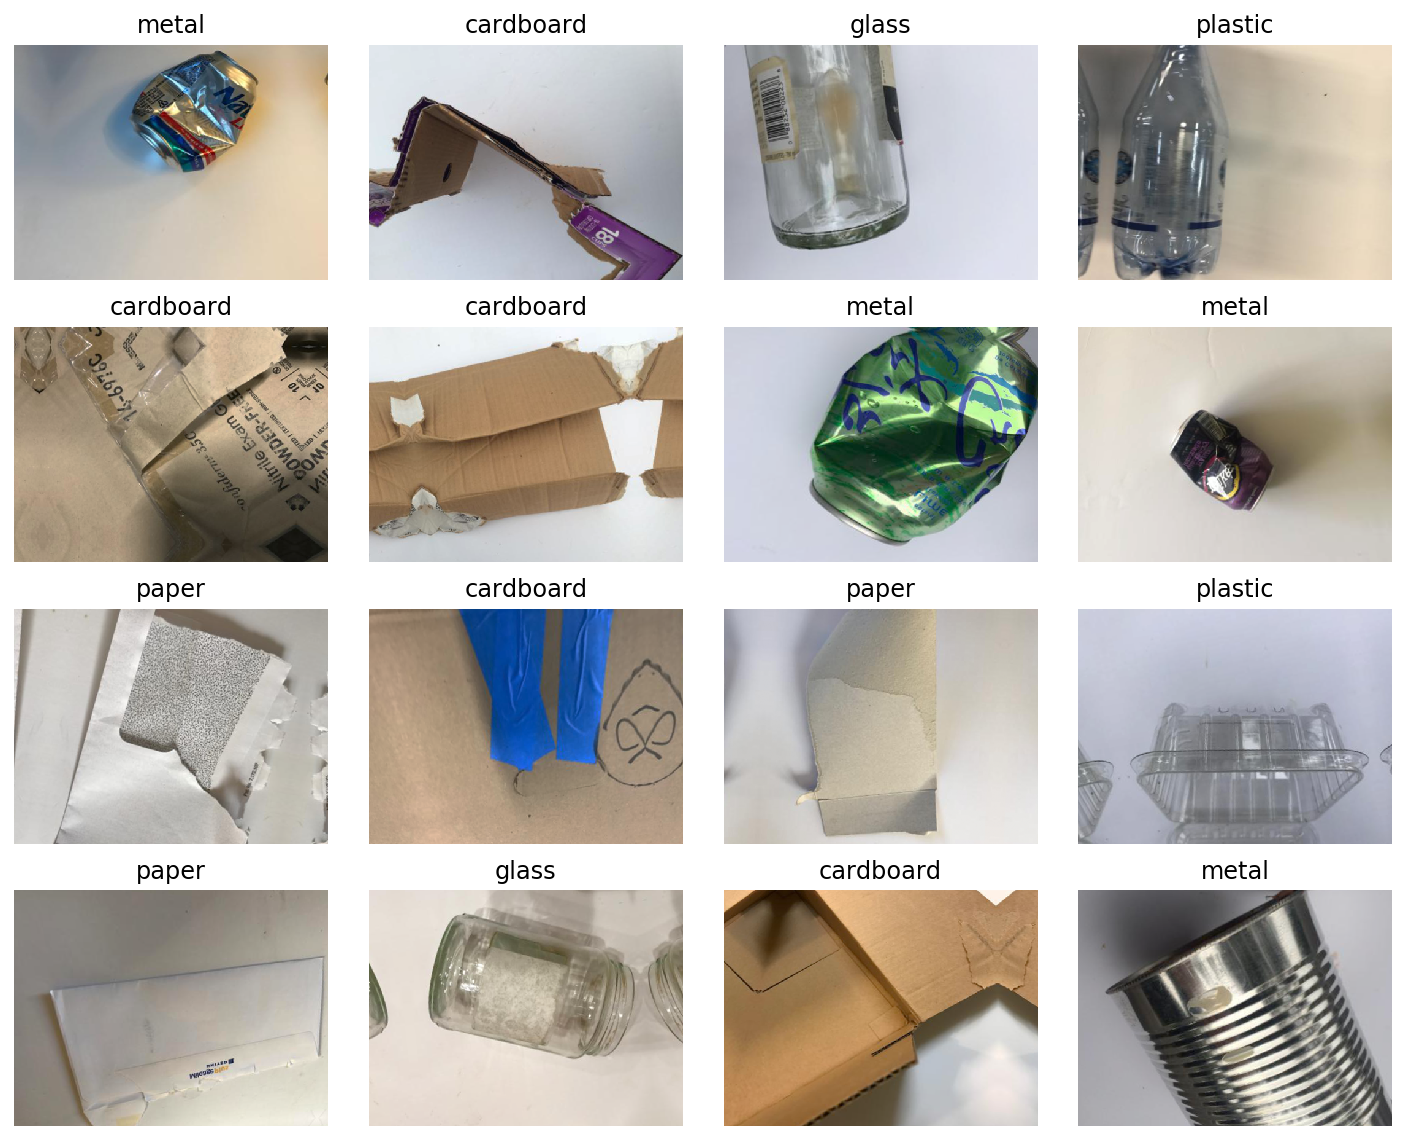

In [6]:
data.show_batch(rows=4,figsize=(10,8))

In [8]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [8]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


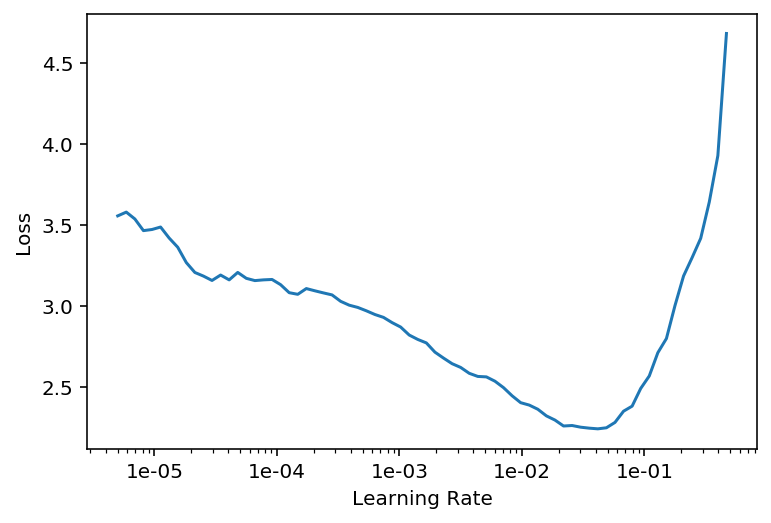

In [9]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [10]:
#주의사항 :: 시간 엄청 오래걸림 dlrjgkfckfP~~
learn.fit_one_cycle(1,max_lr=5.13e-03) 

epoch,train_loss,valid_loss,error_rate,time
0,1.330292,0.709229,0.219048,01:27


In [11]:
interp = ClassificationInterpretation.from_learner(learn) 
losses,idxs = interp.top_losses()

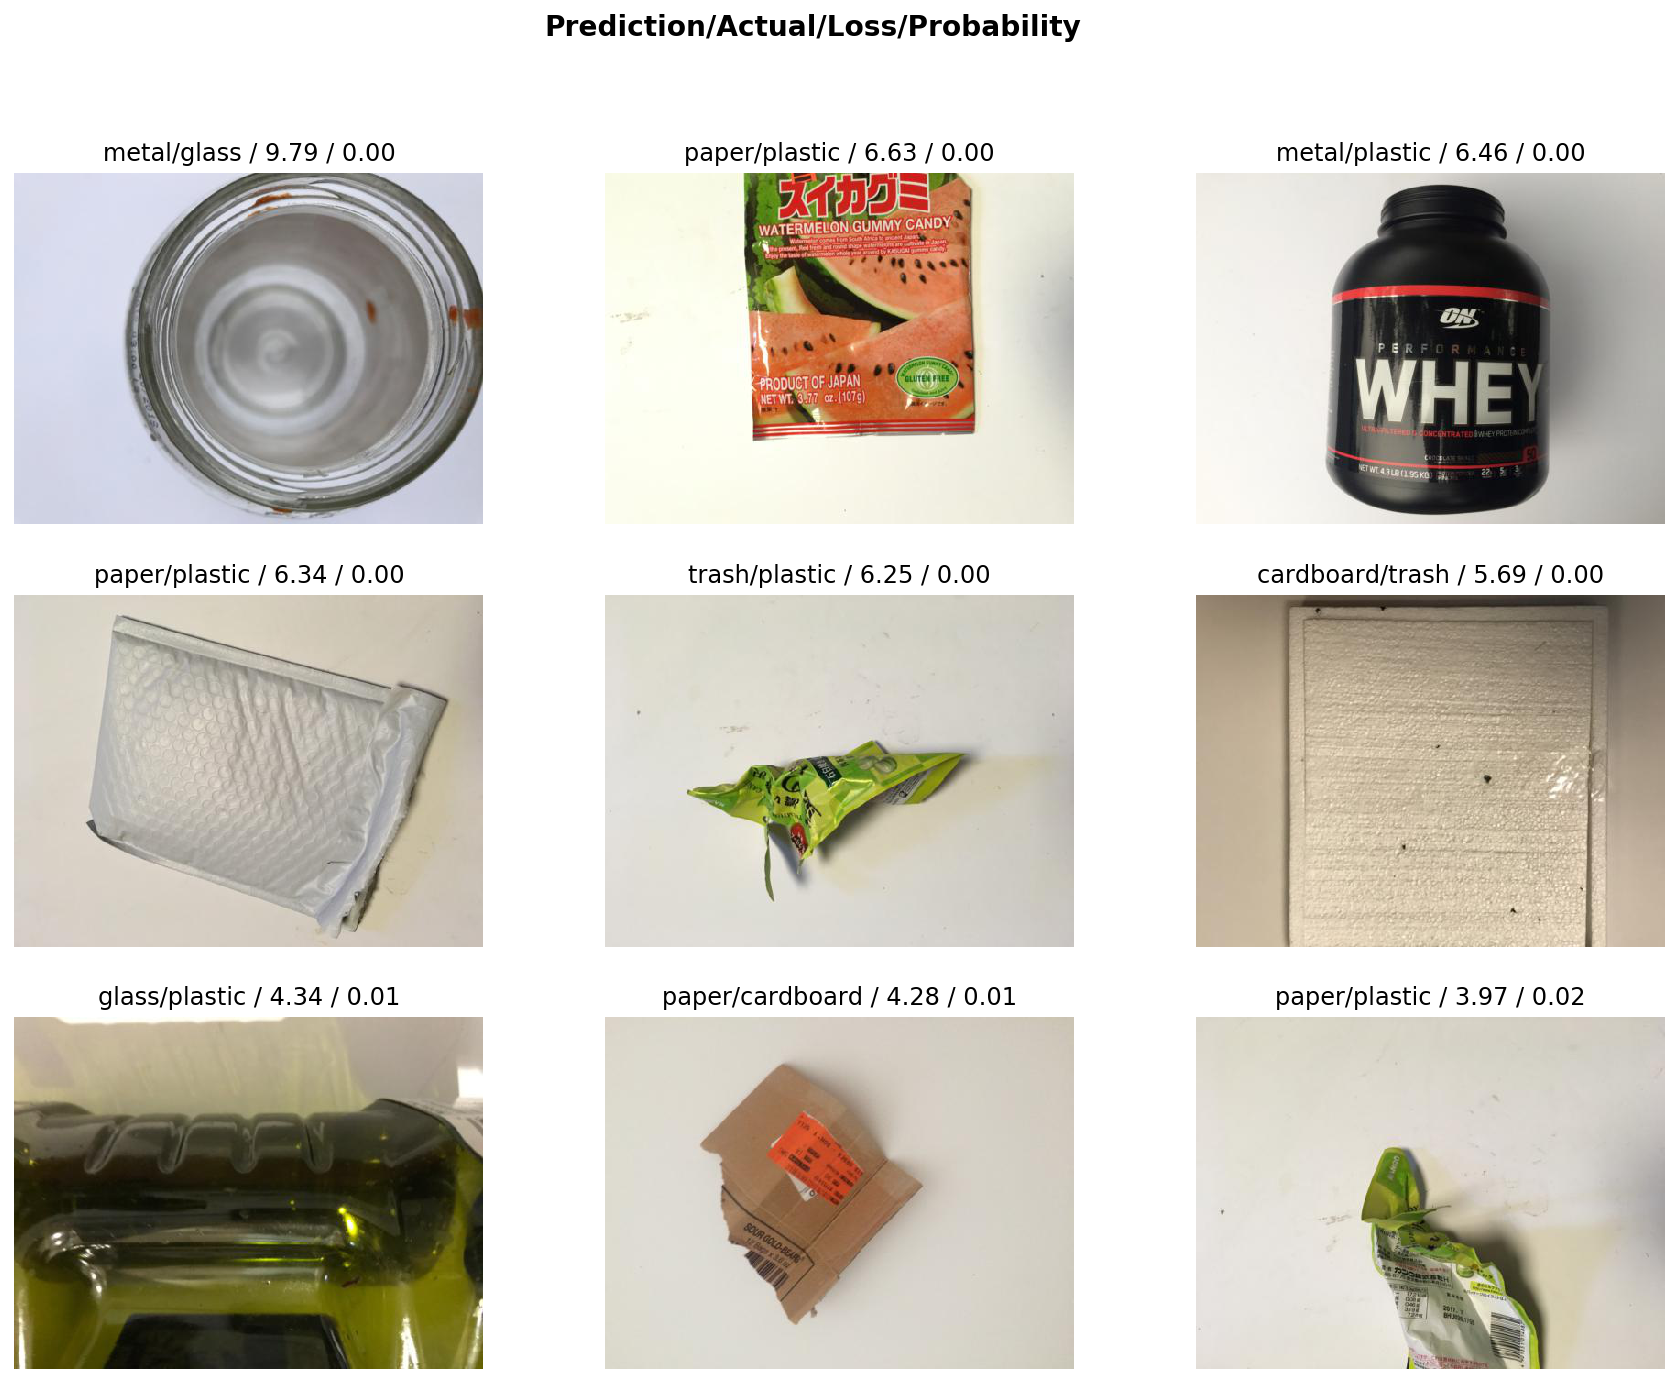

In [12]:
interp.plot_top_losses(9, figsize=(15,11)) #

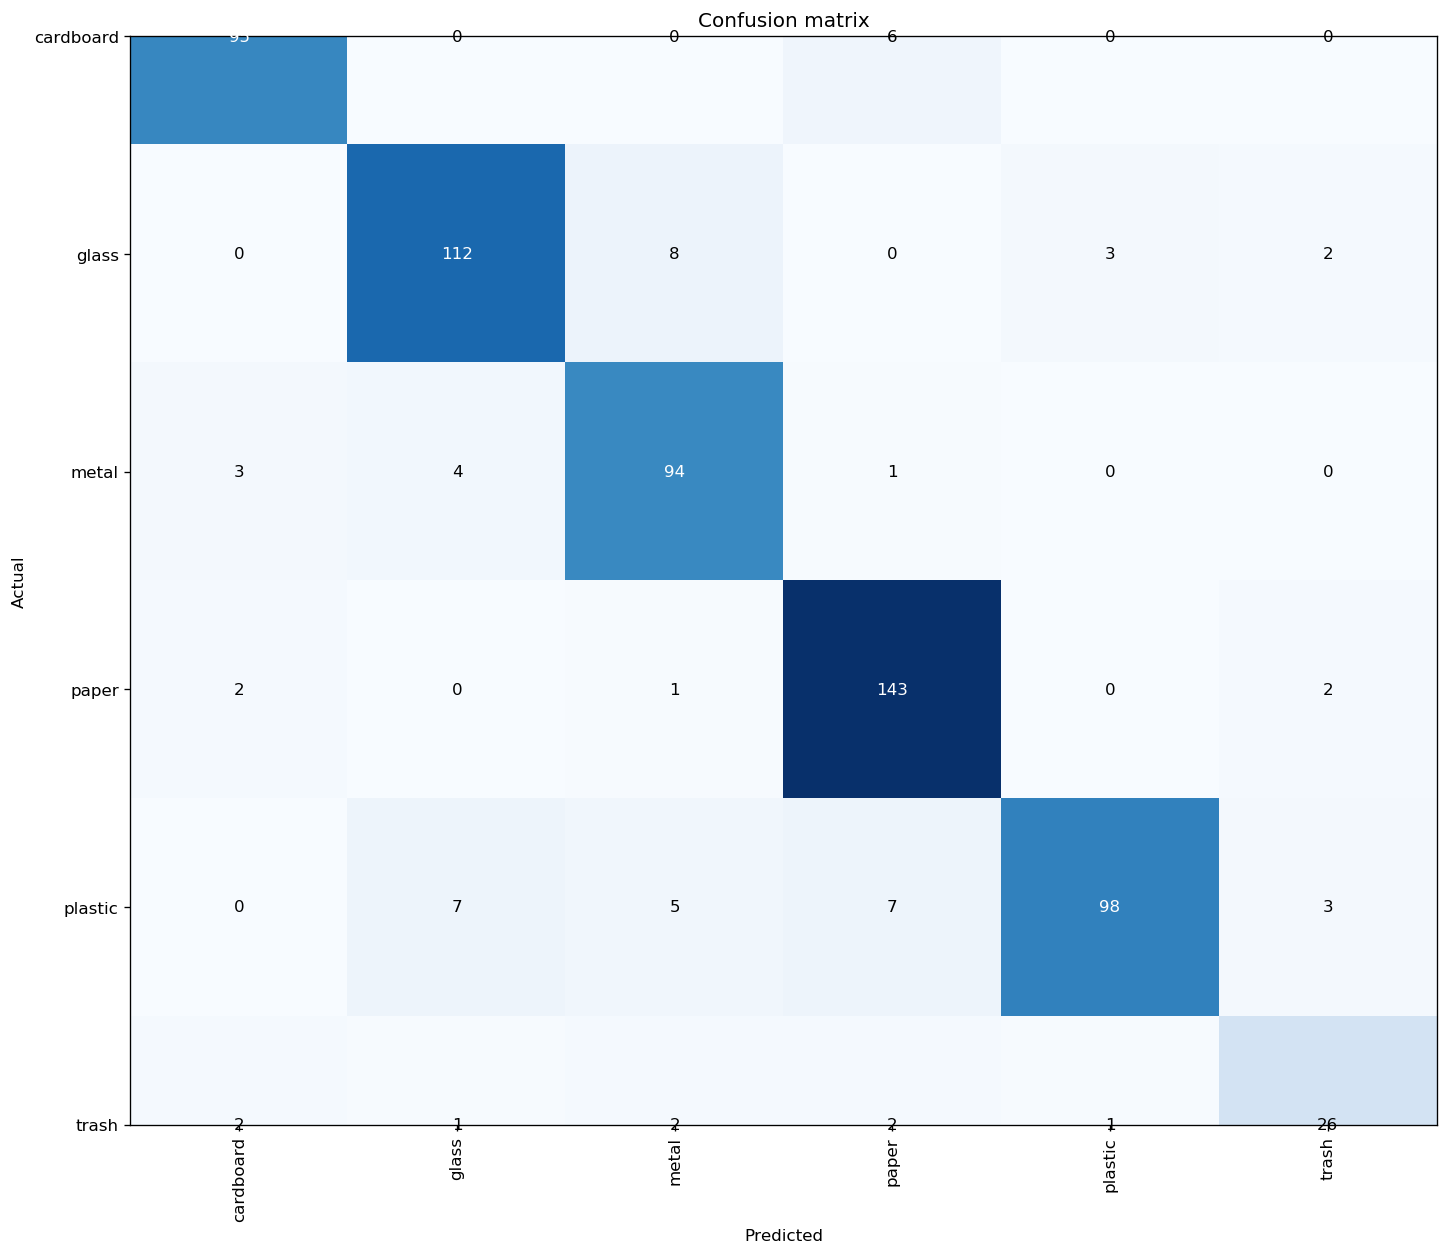

In [13]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [14]:
interp.most_confused(min_val=2)

[('glass', 'metal', 8),
 ('plastic', 'glass', 7),
 ('plastic', 'paper', 7),
 ('cardboard', 'paper', 6),
 ('plastic', 'metal', 5),
 ('metal', 'glass', 4),
 ('glass', 'plastic', 3),
 ('metal', 'cardboard', 3),
 ('plastic', 'trash', 3),
 ('glass', 'trash', 2),
 ('paper', 'cardboard', 2),
 ('paper', 'trash', 2),
 ('trash', 'cardboard', 2),
 ('trash', 'metal', 2),
 ('trash', 'paper', 2)]

In [15]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [16]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[9.9997e-01, 5.8091e-09, 3.1179e-07, 2.5240e-05, 1.0062e-08, 4.3136e-06],
        [1.0000e+00, 4.3369e-10, 3.0485e-08, 9.9533e-07, 3.8263e-07, 6.1675e-07],
        [1.0000e+00, 1.2697e-12, 2.0104e-08, 7.2748e-07, 1.9510e-10, 1.5160e-08],
        ...,
        [9.6157e-04, 5.5716e-05, 1.0957e-04, 3.1919e-01, 4.3841e-03, 6.7530e-01],
        [6.3864e-04, 5.9965e-04, 6.1055e-05, 7.4251e-01, 6.8205e-05, 2.5612e-01],
        [9.1690e-01, 2.8206e-04, 1.3030e-03, 3.9167e-02, 1.0124e-03, 4.1339e-02]])

In [ ]:
## saves the index (0 to 5) of most likely (max) predicted class for each image

# max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [ ]:
# yhat = []
# for max_idx in max_idxs:
#     yhat.append(data.classes[max_idx])

In [17]:
learn.save('5_test_model')

In [20]:
learn

C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\A

Learner(data=ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\multicampus\Desktop\test\data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
cardboard,cardboard,cardboard,cardboard,cardboard
Path: C:\Users\multicampus\Desktop\test\data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: C:\Users\multicampus\Desktop\test\data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): 

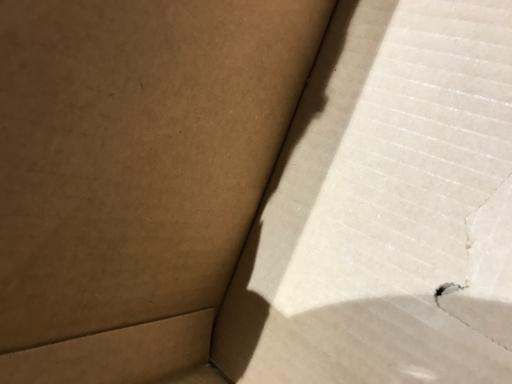

In [22]:
learn.data.test_ds[0][0]

In [ ]:
# y = []

# ## convert POSIX paths to string first
# for label_path in data.test_ds.items:
#     y.append(str(label_path))
    
# ## then extract waste type from file path
# pattern = re.compile("([a-z]+)[0-9]+")
# for i in range(len(y)):
#     y[i] = pattern.search(y[i]).group(1)

In [ ]:
# ## predicted values
# print(yhat[0:5])
# ## actual values
# print(y[0:5])

In [ ]:
# learn.data.test_ds[0][0]

In [ ]:
# cm = confusion_matrix(y,yhat)
# print(cm)

In [ ]:
# df_cm = pd.DataFrame(cm,waste_types,waste_types)

# # plt.figure(figsize=(10,8))
# sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [ ]:
# correct = 0

# for r in range(len(cm)):
#     for c in range(len(cm)):
#         if (r==c):
#             correct += cm[r,c]

In [ ]:
# accuracy = correct/sum(sum(cm))
# accuracy

In [23]:
path

WindowsPath('C:/Users/multicampus/Desktop/test/data')

In [24]:
print(learn.predict(open_image(f'{path}/1.jpg'))[0])

metal


In [2]:
ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss

NameError: name 'create_cnn' is not defined

In [1]:
# 여기서부터 하고싶다~ 이말이야

%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob

from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [9]:
path = Path(os.getcwd())/"data"

tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)


learn = create_cnn(data,models.resnet34,metrics=error_rate)

# learn1 = learn.load("2_test_model")
learn1 = learn.load("sy")

# print(learn1.predict(open_image(f'{path}/4.jpg'))[0])
# print(learn2.predict(open_image(f'{path}/4.jpg'))[0])

images = glob(f'{path}/images/*.jpg')
print('전체 이미지 갯수 :', len(images))

result = {}
# result2 = {}
cnt = 0
for i in images:
    cnt += 1
    if cnt>100:
        break  
    answer = learn1.predict(open_image(i))[0]
    
#     if answer.obj!='metal':
#         print(i, ':' ,answer.obj)
    
    if answer.obj not in result.keys():

        result.update({answer.obj:1})
    else:
        result[answer.obj]+=1
        
print(result)

# cnt = 0
# learn2 = learn.load("5_test_model")
# for i in images:
#     cnt += 1
#     if cnt>100:
#         break      
#     answer2 = learn2.predict(open_image(i))[0]

#     if answer2.obj not in result2.keys():
#         result2.update({answer2.obj:1})
#     else:
#         result2[answer2.obj]+=1
        

# print(result2)



C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\Anaconda3\envs\now\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
C:\Users\multicampus\A

AttributeError: 'ResNet' object has no attribute 'keys'